# Project 2 - Forecasting Service Metrics

Authors: Tatiana Barrios, Anisha Anandkrishnan

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import os
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from pandas import concat
import seaborn as sns
import scipy.stats as st

%matplotlib inline

# Task III - Time series analysis

1. In this task, we apply traditional univariate time-series analysis methods. This means we only consider the target values y(t) of the trace and do not consider the input values x(t)

2. Outliers elimination. Before applying any method, we remove outliers if there are any. Use one of the methods from project 1 (Advanced) to eliminate the outliers.

In [2]:
X = pd.read_csv('X.csv')
Y = pd.read_csv('Y.csv')
X.index = pd.to_datetime(X['TimeStamp'])
Y.index = pd.to_datetime(Y['TimeStamp'])
X_dropped = X.drop(labels=["Unnamed: 0", "TimeStamp"], axis=1, inplace=False)
Y_dropped = Y.drop(labels=["Unnamed: 0", "TimeStamp"], axis=1, inplace=False)
X_preprocessed = pd.DataFrame()
X_tmp = preprocessing.StandardScaler().fit_transform(X_dropped)
for i, n in enumerate(X_dropped):
        X_preprocessed[n] = X_tmp[:, i]

/home/tatiana/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/tatiana/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [3]:
#converting Y_dropped to make it of the same form as X_preprocessed
Y_new = pd.DataFrame()
Y_tmp=Y_dropped.to_numpy()

for i, n in enumerate(Y_dropped):
        Y_new[n] = Y_tmp[:, i]  
# outlier rejection   
remove = []
for i in X_preprocessed:
    for j in range(len(X_preprocessed[i])):
        if j not in remove and abs(X_preprocessed[i][j]) > 80:
            remove.append(j)
X_clean = X_preprocessed.drop(labels=remove, axis=0, inplace=False)
Y_clean = Y_new.drop(labels=remove, axis=0, inplace=False)

print("Number of dropped samples: ", (len(remove)))
%store X_clean
%store Y_clean

Number of dropped samples:  136
Stored 'X_clean' (DataFrame)
Stored 'Y_clean' (DataFrame)


In [4]:
X_clean = X_clean.reset_index()
Y_clean = Y_clean.reset_index()

In [5]:
Y_clean = Y_clean.drop(Y_clean.columns[0], axis=1)

In [6]:
Y_clean.head()

,ReadsAvg,WritesAvg
0,59.1331,118.7723
1,59.8588,118.4950
2,57.8251,116.8042
3,63.8154,128.3462
4,57.4993,118.2260


In [7]:
Y_clean = Y_clean.drop(labels=["WritesAvg"], axis=1)

In [8]:
Y_clean.head()

,ReadsAvg
0,59.1331
1,59.8588
2,57.8251
3,63.8154
4,57.4993


In [14]:
features_file = 'FedCSIS_X.csv'
targets_file = 'FedCSIS_Y.csv'
directory = 'FedCSIS'

fn1 = os.path.join(directory, features_file)
fn2 = os.path.join(directory, targets_file)

Xfed = pd.read_csv(fn1)
Yfed = pd.read_csv(fn2)

In [22]:
Xfed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 9 columns):
host1619_/dev/shm      1917 non-null float64
host1619_cpu_idle      1917 non-null float64
host1619_cpu_iowait    1917 non-null float64
host1619_cpu_sys       1917 non-null float64
host1619_cpu_user      1917 non-null float64
host1619_memory.0      1917 non-null float64
host1619_memory.1      1917 non-null float64
host1619_memory.2      1917 non-null float64
host1619_memory.3      1917 non-null float64
dtypes: float64(9)
memory usage: 134.9 KB


In [23]:
Yfed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1917 entries, 0 to 1916
Data columns (total 1 columns):
host1619_/    1917 non-null float64
dtypes: float64(1)
memory usage: 15.1 KB


In [16]:
Yfed.head()

,Unnamed: 0,host1619_/
0,0,0.025145
1,1,0.036997
2,2,0.048848
3,3,0.014863
4,4,0.020468


In [17]:
Xfed = Xfed.drop(Xfed.columns[0], axis=1)

In [18]:
Yfed = Yfed.drop(Yfed.columns[0], axis=1)

In [19]:
Yfed.head()

,host1619_/
0,0.025145
1,0.036997
2,0.048848
3,0.014863
4,0.020468


In [24]:
hostdata = Yfed['host1619_/']

Text(0.5, 1.0, 'Time series of FedCSIS data')

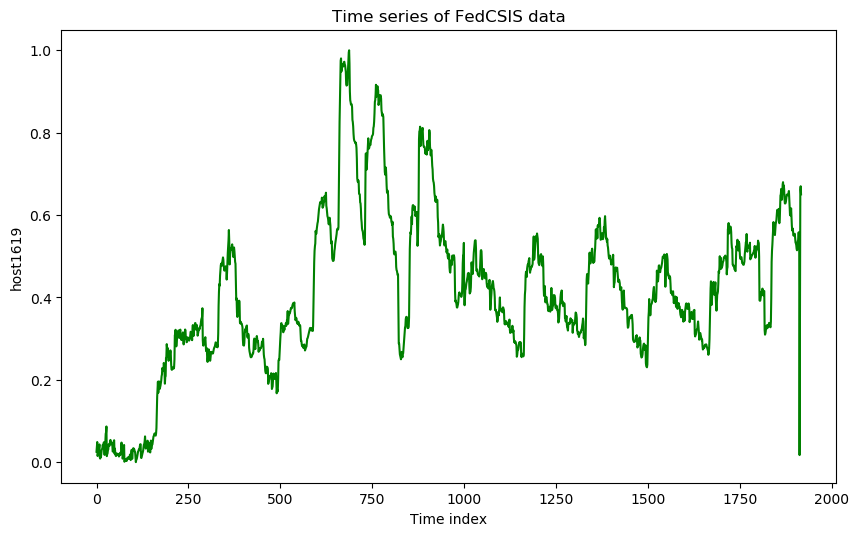

In [28]:
#Time series of this plot
fig_, linep_ = plt.subplots(figsize = (10,6), dpi = 100)
linep_ = sn.lineplot(data=hostdata, color='green')
linep_.set(xlabel='Time index', ylabel='host1619')

linep_.set_title("Time series of FedCSIS data")

In [29]:
fig_.savefig('timesDT1.png', dpi=300, bbox_inches='tight')

Text(0.5, 1.0, 'Density and histogram for target in FedCSIS data')

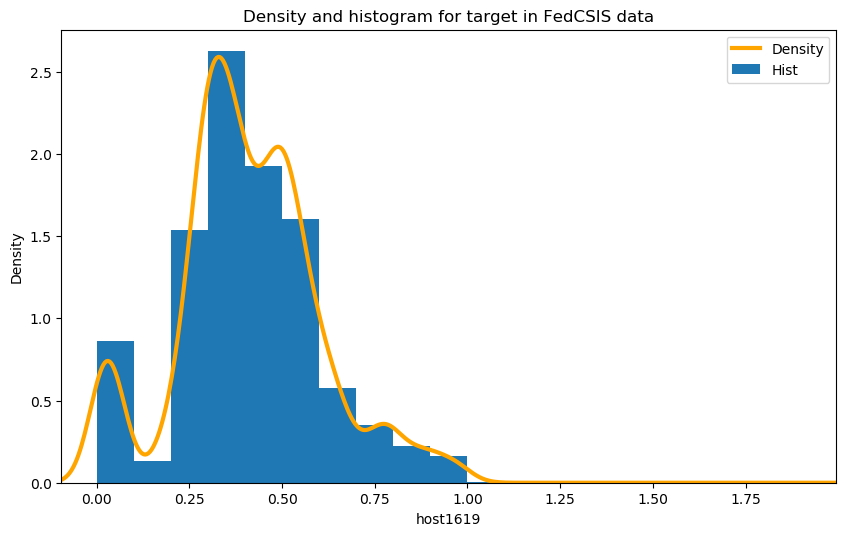

In [40]:
fig, ax1 = plt.subplots(figsize = (10,6), dpi = 100)
mn_point = min(hostdata)
mx_point = max(hostdata)
bins = np.arange(mn_point, mx_point + 1, 0.1)
dens_vals = ax1.hist(hostdata, density=True, bins=bins, label='Hist')
mn_point, mx_point = plt.xlim()
plt.xlim(mn_point, mx_point)

#Kernel density estimation
kde = st.gaussian_kde(hostdata)
kde_x = np.linspace(mn_point, mx_point, 500)
ax1.plot(kde_x, kde.pdf(kde_x), color='orange', label='Density', linewidth=3.0)
plt.legend(loc="upper right")
plt.xlabel('host1619')
plt.ylabel('Density')
plt.title('Density and histogram for target in FedCSIS data')

In [41]:
fig.savefig('densitytargetfcsis.png', dpi=300, bbox_inches='tight')

In [20]:
Xfed_preprocessed = pd.DataFrame()
Xfed_tmp = preprocessing.StandardScaler().fit_transform(Xfed)
for i, n in enumerate(Xfed):
        Xfed_preprocessed[n] = Xfed_tmp[:, i]

In [44]:
Xfed.describe(percentiles=[.25, .95])

,host1619_/dev/shm,host1619_cpu_idle,host1619_cpu_iowait,host1619_cpu_sys,host1619_cpu_user,host1619_memory.0,host1619_memory.1,host1619_memory.2,host1619_memory.3
count,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000,1917.000000
mean,0.342723,0.654299,0.418802,0.359165,0.377096,0.841901,0.484631,0.478202,0.740316
std,0.470492,0.289803,0.300691,0.286012,0.289992,0.133268,0.274356,0.278042,0.192699
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.384615,0.192308,0.200000,0.111111,0.782191,0.229027,0.206778,0.621646
50%,0.000000,0.769231,0.346154,0.200000,0.222222,0.893017,0.447973,0.521411,0.796959
95%,1.000000,0.961538,0.923077,0.800000,0.888889,0.964126,0.897756,0.924681,0.957245
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [45]:
#converting Y_dropped to make it of the same form as X_preprocessed
Yfed_new = pd.DataFrame()
Yfed_tmp=Yfed.to_numpy()

for i, n in enumerate(Yfed):
        Yfed_new[n] = Yfed_tmp[:, i]  
# outlier rejection   
remove = []
for i in Xfed_preprocessed:
    for j in range(len(Xfed_preprocessed[i])):
        if j not in remove and abs(Xfed_preprocessed[i][j]) > 3:
            remove.append(j)
Xfed_clean = Xfed_preprocessed.drop(labels=remove, axis=0, inplace=False)
Yfed_clean = Yfed_new.drop(labels=remove, axis=0, inplace=False)

print("Number of dropped samples: ", (len(remove)))
%store Xfed_clean
%store Yfed_clean

Number of dropped samples:  49
Stored 'Xfed_clean' (DataFrame)
Stored 'Yfed_clean' (DataFrame)


In [46]:
Xfed_clean.describe(percentiles=[.25, .95])

,host1619_/dev/shm,host1619_cpu_idle,host1619_cpu_iowait,host1619_cpu_sys,host1619_cpu_user,host1619_memory.0,host1619_memory.1,host1619_memory.2,host1619_memory.3
count,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000,1868.000000
mean,0.011146,-0.021173,0.027298,0.023962,-0.035227,0.074520,0.015012,-0.033493,0.026389
std,1.003689,1.004050,0.998151,1.000548,0.984079,0.836074,1.007104,0.989083,0.963550
min,-0.728625,-2.258326,-1.393163,-1.256099,-1.300703,-2.996523,-1.766891,-1.720341,-2.904964
25%,-0.728625,-0.930819,-0.753443,-0.556644,-0.917451,-0.386856,-0.938414,-0.987533,-0.592780
50%,-0.728625,0.396689,-0.241667,-0.556644,-0.534199,0.402896,-0.073582,0.119803,0.312593
95%,1.397364,1.060442,1.677492,1.541718,1.765311,0.917376,1.509868,1.566766,1.128126
max,1.397364,1.193193,1.933380,2.241173,2.148563,1.186637,1.878958,1.877182,1.347969


In [48]:
hostdata_cln = Yfed_clean['host1619_/']

In [49]:
fedcsis_everything = Xfed_clean.join(hostdata_cln) 
gen_corr_mat = fedcsis_everything.corr()
print(gen_corr_mat)

                     host1619_/dev/shm  host1619_cpu_idle  \
host1619_/dev/shm             1.000000           0.080653   
host1619_cpu_idle             0.080653           1.000000   
host1619_cpu_iowait          -0.010558          -0.971791   
host1619_cpu_sys             -0.057752          -0.966752   
host1619_cpu_user            -0.208151           0.577394   
host1619_memory.0             0.199884          -0.490687   
host1619_memory.1            -0.123609          -0.883650   
host1619_memory.2            -0.191730           0.780107   
host1619_memory.3             0.060657          -0.295618   
host1619_/                    0.254040          -0.100870   

                     host1619_cpu_iowait  host1619_cpu_sys  host1619_cpu_user  \
host1619_/dev/shm              -0.010558         -0.057752          -0.208151   
host1619_cpu_idle              -0.971791         -0.966752           0.577394   
host1619_cpu_iowait             1.000000          0.972157          -0.747944   
host

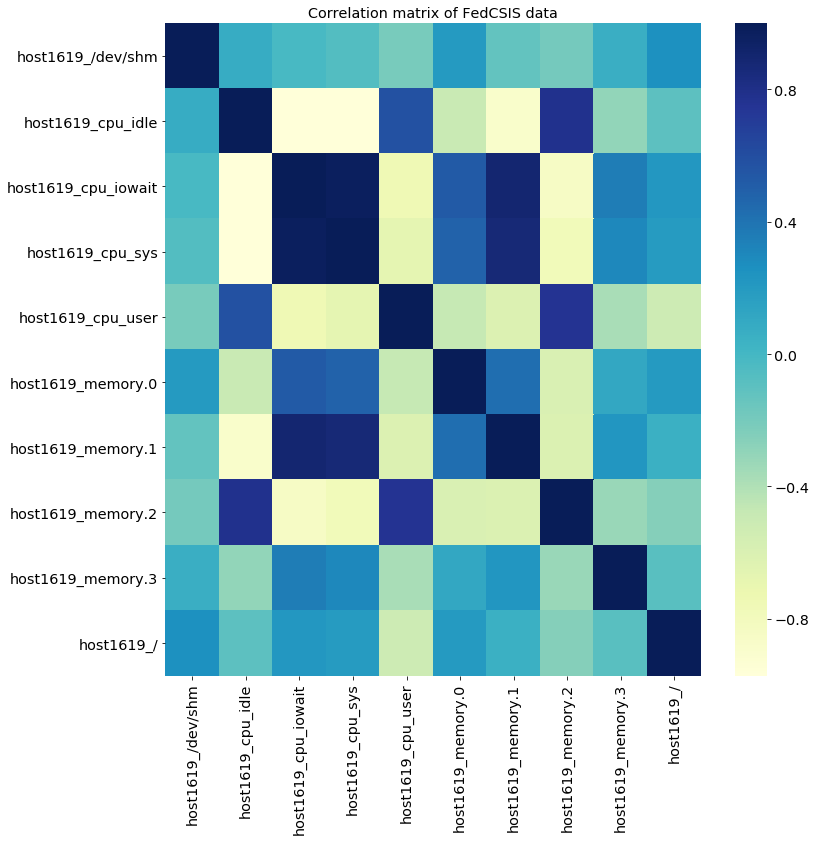

In [50]:
#Heatmap of correlation matrix
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 12),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
heatmaplt = sn.heatmap(gen_corr_mat, cmap="YlGnBu")
heatmaplt.set_title('Correlation matrix of FedCSIS data')
plt.show()

In [51]:
fig = heatmaplt.get_figure()
fig.savefig('corrmat_fedcsis.png', dpi=300, bbox_inches='tight')

3. The auto-correlation function (ACF) computes the correlation of observations in a time series with respect to lag values. Compute the values of this function for the KTH trace and the FedCSIS trace. For each trace, plot the ACF values (correlogram) in two ways.The first plot shows the lag values in the interval l = 0; :::; 100, the second plot shows in the interval l = 0; :::; 4000. The x-axis of the plots shows the lag values and the y-axis shows the correlation coefficients (Pearson correlation) with values between -1 and 1 for negative and positive correlation, respectively.

[Text(0, 0.5, 'Coefficients'), Text(0.5, 0, 'lag')]

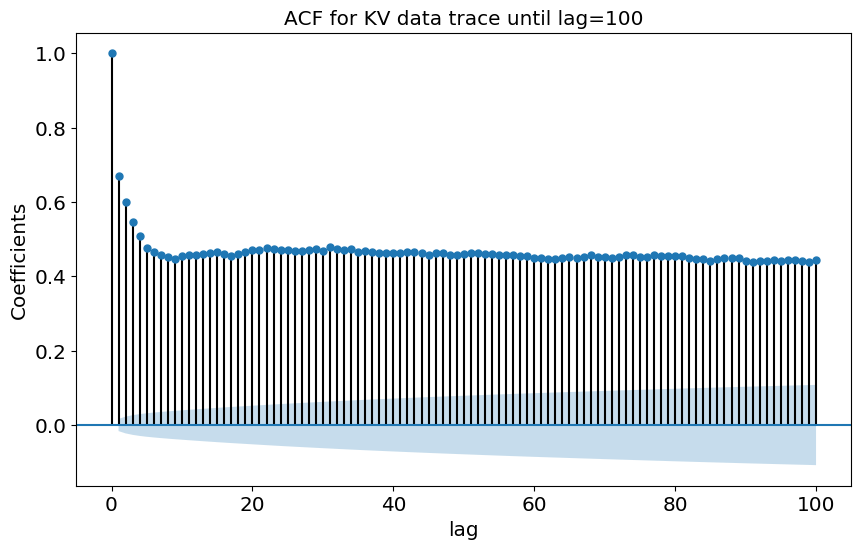

In [52]:
# For the KTH trace (KV_periodic)
fig, plotss = plt.subplots(figsize = (10,6), dpi = 100)

plot_acf(x=Y_clean, lags=100, ax=plotss)
plotss.set(title="ACF for KV data trace until lag=100")
plotss.set(xlabel='lag', ylabel='Coefficients')

In [53]:
fig.savefig('kv_acf100.png', dpi=300, bbox_inches='tight')

[Text(0, 0.5, 'Coefficients'), Text(0.5, 0, 'lag')]

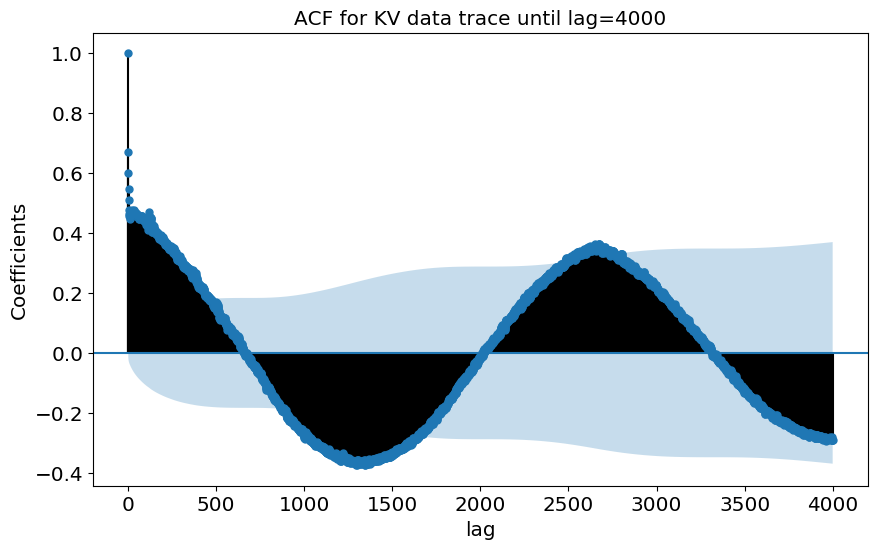

In [54]:
fig, plotss = plt.subplots(figsize = (10,6), dpi = 100)

plot_acf(x=Y_clean, lags=4000, ax=plotss)
plotss.set(title="ACF for KV data trace until lag=4000")
plotss.set(xlabel='lag', ylabel='Coefficients')

In [55]:
fig.savefig('kv_acf4000.png', dpi=300, bbox_inches='tight')

[Text(0, 0.5, 'Coefficients'), Text(0.5, 0, 'lag')]

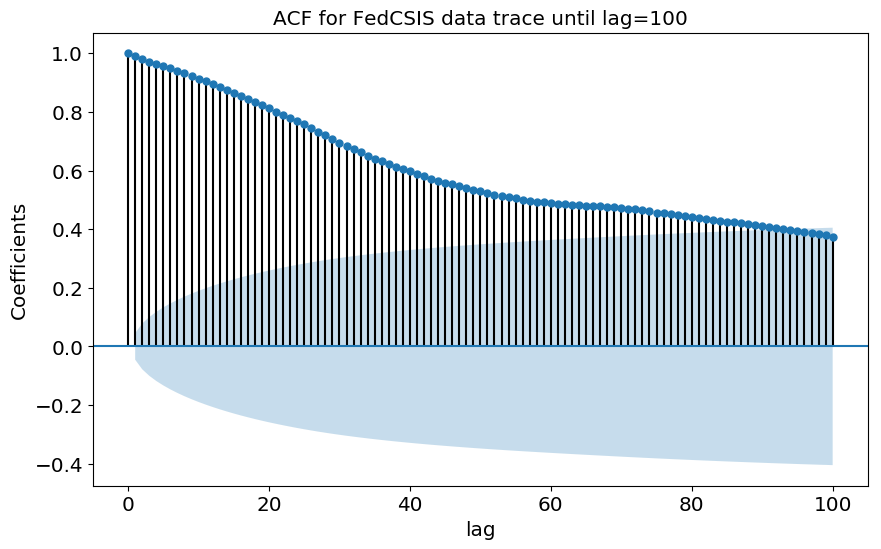

In [56]:
# For the FedCSIS trace
fig, plotss = plt.subplots(figsize = (10,6), dpi = 100)

plot_acf(x=Yfed_clean, lags=100, ax=plotss)
plotss.set(title="ACF for FedCSIS data trace until lag=100")
plotss.set(xlabel='lag', ylabel='Coefficients')

In [57]:
fig.savefig('fed_acf100.png', dpi=300, bbox_inches='tight')

In [61]:
Yfed_clean.shape

(1868, 1)

[Text(0, 0.5, 'Coefficients'), Text(0.5, 0, 'lag')]

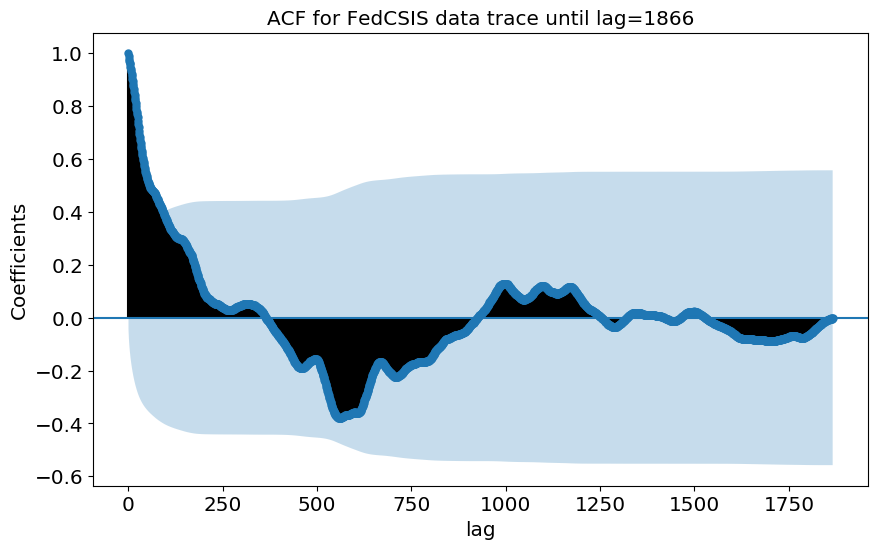

In [63]:
fig, plotss = plt.subplots(figsize = (10,6), dpi = 100)

plot_acf(x=Yfed_clean, lags=1866, ax=plotss)
plotss.set(title="ACF for FedCSIS data trace until lag=1866")
plotss.set(xlabel='lag', ylabel='Coefficients')

In [64]:
fig.savefig('fed_acf4000.png', dpi=300, bbox_inches='tight')

# Task IV - Time series forecasting

1. Fit an Autoregression (AR) model to the KTH time series. Perform forecasting using the AR model, which formulates the next step in the sequence as a linear function of the observations at previous time steps. The method is suitable for time series without trend and seasonal components. Evaluate the method for the AR model parameter p = 1; :::; 10.

In [65]:
#Splitting train and test
X_train, X_test, Y_train, Y_test = train_test_split(X_clean, Y_clean, test_size=0.3, shuffle = False)
print(X_train.shape,"(70% of the samples in training set and 16 features)")
Y_train = Y_train.sort_index(axis = 0)
Y_test = Y_test.sort_index(axis = 0)

(10041, 1752) (70% of the samples in training set and 16 features)


In [67]:
from statsmodels.tsa.ar_model import AutoReg

#should we assume that data is non seasonal????
#p=1
model = AutoReg(data, lags=1, seasonal=False).fit()


ImportError: cannot import name 'AutoReg' from 'statsmodels.tsa.ar_model' (/home/tatiana/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py)